In [1]:
pip install langdetect

     |████████████████████████████████| 981 kB 5.2 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993241 sha256=6125933c63fe761158390d39030e6a7c15902c46aa96b465c9ab1dc121da4d58
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [2]:
## import all the necessary libraries
import warnings
#Ignoring unnecessory warnings
warnings.filterwarnings("ignore")                   
import re
import numpy as np                             
import pandas as pd     
from pydrive.auth  import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os                            
import nltk 
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import string
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
download_path = os.path.expanduser('~/data')
try:
  os.makedirs(download_path)
except: pass
file_list = drive.ListFile({'q': "'1KWnpvN0L3MtVZ6b7NJiwnbs8_TQ4oQmT' in parents"}).GetList()
for f in file_list:
  file_id = f['id']
  title = f['title']
  file_name = os.path.join(download_path, title)
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(file_name)

In [5]:
with open(download_path+'/train.ft.txt', encoding="utf8") as f:
    train = f.readlines()


In [6]:
traindf = pd.DataFrame()
def train_process_review(train_txt):
    global traindf
    traindf = pd.DataFrame(train_txt)
    traindf = traindf.sample(frac = 0.5)
    f.close()
    traindf["text"] = traindf[0]
    traindf = traindf.iloc[: , 1:]
    #make label a different column
    traindf['text'] = traindf['text'].str.strip()
    
    #Only underscore sign from the word
    remove_underscore = lambda x: re.sub(r'_','', x)
    traindf['text'] = traindf.text.map(remove_underscore)
    
    #get label
    traindf['label'] = traindf['text'].str[5:6]
    traindf['label']  = traindf['label'].apply(lambda x: 1 if x == '2' else 0)
    traindf['text'] = traindf['text'].str[6:]
    
    #remove numbers
    traindf['text'] = traindf.text.map(lambda x: re.sub('[0-9]+', '', x))
    


In [7]:
train_process_review(train)

In [8]:
with open(download_path+'/test.ft.txt', encoding="utf8") as files:
    test = files.readlines()

In [9]:
testdf = pd.DataFrame()
def test_process_review(test_txt):
    global testdf
    testdf = pd.DataFrame(test_txt)
    #testdf = testdf.sample(frac = 0.5)
    files.close()
    testdf["text"] = testdf[0]
    testdf = testdf.iloc[: , 1:]
    #make label a different column
    testdf['text'] = testdf['text'].str.strip()
    
   
    #Only underscore sign from the word
    remove_underscore = lambda x: re.sub(r'_','', x)
    testdf['text'] = testdf.text.map(remove_underscore)
    
    #get label
    testdf['label'] = testdf['text'].str[5:6]
    testdf['label']  = testdf['label'].apply(lambda x: 1 if x == '2' else 0)
    testdf['text'] = testdf['text'].str[6:]
    
    testdf['text'] = testdf.text.map(lambda x: re.sub('[0-9]+', '', x))


In [10]:
test_process_review(test)

In [11]:
traindf

,text,label
3119292,Dimplex - DF Electric Fireplace Insert: Quick...,1
2888140,Synthesizer!?: Charles Dutoit has excellent c...,0
1112723,Danzon: This movie is worth watching! It has ...,1
3444322,"Too ""preachy"", even for a Christian video: I ...",0
1632878,Taylor failure: I have had Taylor thermometer...,0
...,...,...
1830121,The Final Question: An early HBO film that ga...,1
3453598,Love it!: Finally made more room in my closet...,1
3153382,Compendium of the Catechism of the Catholic C...,1
232781,Buyer Beware!: Only a handful of the themes o...,0


freqs = build_freqs(traindf['text'], traindf['label'])

In [12]:
#apply the count vectorizer and restrict features to words appearing in => 1% of the entire training set

CV = CountVectorizer(max_features = 100000)  


In [13]:

X_test = CV.fit_transform(testdf['text'])
X_train = CV.transform(traindf['text'])
#a,b = X_train.shape
Y_train = traindf['label']
Y_test = testdf['label']

In [14]:
#CV.vocabulary_
#.get_feature_names()
X_test.shape



(400000, 100000)

count_vect_df = pd.DataFrame(X_train.toarray(), columns=CV.get_feature_names())
count_vect_df.head()

# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[0:1000]

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix,f1_score,precision_score,recall_score


In [17]:
#find the best value of C in logisticregression
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, Y_train)
    print('Accuracy for C=%s: %s' % (c, accuracy_score(Y_test, lr.predict(X_test))))

Accuracy for C=0.01: 0.9046075
Accuracy for C=0.05: 0.9047525
Accuracy for C=0.25: 0.9049425
Accuracy for C=0.5: 0.90595
Accuracy for C=1: 0.904885


In [18]:
#final model accuracy
final = LogisticRegression(C = 0.05)
final.fit(X_train, Y_train)
print('Final Model Accuracy: %s' % (accuracy_score(Y_test, final.predict(X_test))))

Final Model Accuracy: 0.9047525


[[180030  19970]
 [ 18129 181871]]


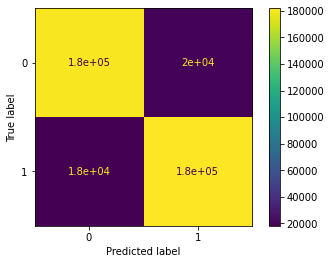

In [19]:
plot_confusion_matrix(final, X_test, Y_test)
print(confusion_matrix(Y_test, final.predict(X_test)))

In [20]:
feature_to_coef = {
    word: coef for word, coef in zip(
    CV.get_feature_names(), final.coef_[0])
}

print('Positive Words')
positive = []
for best_positive in sorted(
    feature_to_coef.items(),
    key=lambda x: x[1],
    reverse=True)[:10]:
    positive += [best_positive]
    print(best_positive)

Positive Words
('excellent', 1.66388712703462)
('outstanding', 1.640096594132357)
('pleased', 1.6085356481767712)
('complaint', 1.5227743574542019)
('superb', 1.4981288824730006)
('refreshing', 1.4527620291287984)
('rocks', 1.3971553964009094)
('fascinating', 1.3718176825317057)
('helps', 1.3696578493379092)
('awesome', 1.3653589632543055)


In [21]:
print('Negative Words')
negative = []
for best_negative in sorted(
    feature_to_coef.items(),
    key=lambda x: x[1])[:10]:
    negative += [best_negative]
    print(best_negative)

Negative Words
('disappointing', -2.975334315946819)
('disappointment', -2.712000176638482)
('poorly', -2.49403749736459)
('useless', -2.1648398224748497)
('awful', -2.1418391247179214)
('worst', -2.0506100035131505)
('mediocre', -1.9701483489083131)
('worthless', -1.9181639316003372)
('junk', -1.798887038476785)
('sucks', -1.7755158438994838)


In [22]:
negative = pd.DataFrame(negative)
positive = pd.DataFrame(negative)


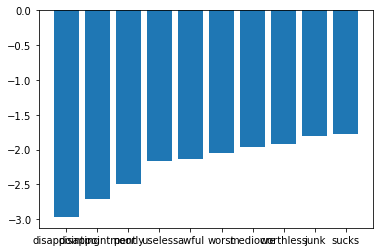

In [23]:
plt.figure()

x = negative[0]
y1 = negative[1]

plt.bar(x, y1)
  
plt.subplots_adjust(wspace = 1)

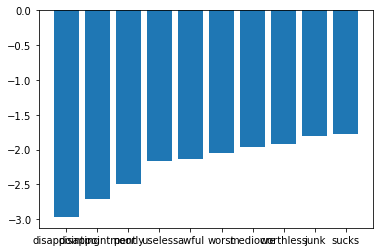

In [24]:
plt.figure()

x2 = positive[0]
y2 = positive[1]

plt.bar(x2, y2)
  
plt.subplots_adjust(wspace = 1)

In [25]:
def create_wordcloud(text):
    
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
    max_words=3000,
    stopwords=stopwords,
    repeat=True)
    wc.generate(str(text))
    
    print("Word Cloud Saved Successfully")
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout(pad = 0)
 
    return plt.show()

Word Cloud Saved Successfully


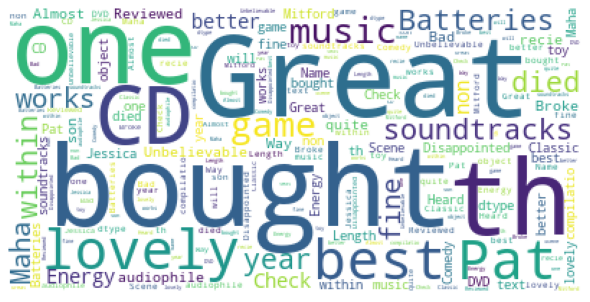

In [26]:
#Creating wordcloud for positive sentiment
create_wordcloud(testdf["text"])


In [36]:
print(f1_score(Y_test,final.predict(X_test), average="macro"))
print(precision_score(Y_test, final.predict(X_test), average="macro"))
print(recall_score(Y_test, final.predict(X_test), average="macro"))

0.9047504823288719
0.9047867984051221
0.9047525000000001
